In [1]:
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
# warnings.filterwarnings("error", category=RuntimeWarning)

from aeons.lm_partial import analytic_lm_params, X_end_formula
from aeons.covariance import X_mu, X_Sigmainv, logX_mu, points_at_iteration
from aeons.true_distribution import generate_Xs, nk_dead, nk_dead_live, nk_live
from aeons.likelihoods import likelihood, full
from aeons.models import LS, CG
from aeons.endpoint import EndModel

In [2]:
from aeons.toy_samples import gaussian_samples
from scipy.special import gammainc, gamma, logsumexp, loggamma, gammaincinv

def logXf_formula(theta, logZdead, Xi, epsilon=1e-3):
    logLmax, d, sigma = theta
    loglive = np.log( gamma(d/2) * gammainc(d/2, Xi**(2/d)/(2*sigma**2)) )
    logdead = logZdead - logLmax - (d/2)*np.log(2) - d*np.log(sigma) + np.log(2/d)
    logend = logsumexp([loglive, logdead]) + np.log(epsilon)
    xf_reg = gammaincinv(d/2, np.exp(logend)/gamma(d/2))
    return d/2 * np.log(2*sigma**2 * xf_reg)

def logXf_formula_gaussian(theta, epsilon=1e-3):
    _, d, sigma = theta
    return d/2*np.log(2) + d * np.log(sigma) + loggamma(1 + d/2) + np.log(epsilon)

def end_iteration(samples, N, start=0.5, epsilon=1e-3):
    iterations = np.linspace(len(samples) * start, len(samples), N, endpoint=False).astype(int)
    for ndead in iterations:
        ndead = int(ndead)
        points = points_at_iteration(samples, ndead)
        weights = points.get_weights()
        if weights[ndead:].sum()/weights.sum() < epsilon:
            return ndead

def minimise_bandwidth(logL, X_mean, ndead, alphas, x0, warnings=False, give_alpha=False):
    theta_best = analytic_lm_params(logL[ndead:], X_mean[ndead:], x0)
    alpha_best = 0
    logZi = -np.inf
    for alpha in alphas:
        startf = int(ndead * (1 - alpha))
        logLf = logL[startf:]
        X_meanf = X_mean[startf:]
        ls = LS(logL, full, X_mean)
        theta = analytic_lm_params(logLf, X_meanf, x0)
        try:
            logZf = ls.logZ(theta) + startf * np.log(startf)
        except RuntimeWarning:
            if warnings:
                print(np.round(theta, 2), 'warning', alpha)
            continue
        if logZf > logZi:
            theta_best = theta
            alpha_best = alpha
    if give_alpha:
        print(alpha_best)
    return theta_best


#### Pure Gaussian

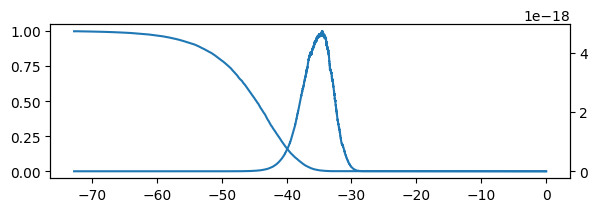

In [3]:
from aeons.toy_samples import gaussian_samples, correlated_gaussian_samples
nlive = 500
d, sigma = 10, 0.01
samples = gaussian_samples(nlive, d, sigma)
gauss = EndModel(samples)
gauss.plot_lx()

In [5]:
logXf_true = gauss.logXf_true(N=200, start=0.5)
logXf_true

-44.5774374069095

In [8]:
N = 25
iterations = np.linspace(100, 25000, N, endpoint=False).astype(int)
logXfs = gauss.logXfs(iterations, Nset=25)

In [11]:
iterations

array([  100,  2590,  5080,  7570, 10060, 12550, 15040, 17530, 20020,
       22510])

(0.0, 28000.0)

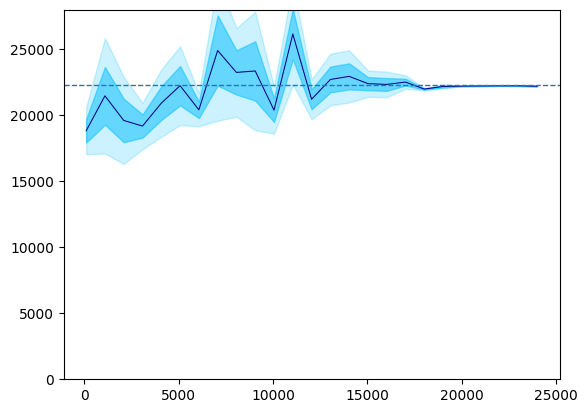

In [9]:
plt.plot(iterations, logXfs[0] * (-500), color='navy', lw=.75)
plt.fill_between(iterations, (logXfs[0] - logXfs[1]) * -500, (logXfs[0] + logXfs[1]) * -500, color='deepskyblue', alpha=0.5)
plt.fill_between(iterations, (logXfs[0] - 2*logXfs[1]) * -500, (logXfs[0] + 2*logXfs[1]) * -500, color='deepskyblue', alpha=0.2)
plt.axhline(logXf_true * (-500), lw=1, ls='--')
plt.ylim(0, 28000)

In [59]:
from scipy.special import logsumexp
ndead = 9064
points = points_at_iteration(samples, ndead)
logL = np.array(points.logL)
nk = np.array(points.nlive)
logXf_i = []
for _ in range(50):
    X = generate_Xs(nk)
    theta = analytic_lm_params(logL[ndead:], X[ndead:], 1)
    logZdead = logsumexp(points.logw()[:ndead])
    logXf_i.append(logXf_formula(theta, logZdead, X[ndead]))
logXf_i = np.array(logXf_i)
ends = logXf_i * -500

/tmp/ipykernel_66323/2657350571.py:9: RuntimeWarning: invalid value encountered in double_scalars
  xf_reg = gammaincinv(d/2, np.exp(logend)/gamma(d/2))


In [60]:
ends.mean(), ends.std()

(nan, nan)

#### Correlated Gaussian

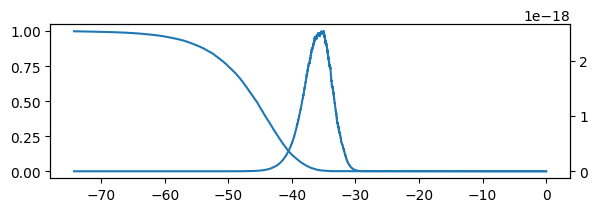

In [10]:
nlive = 500
d, sigma = 10, 0.01
samples = correlated_gaussian_samples(nlive, d, sigma)
cgauss = EndModel(samples)
cgauss.plot_lx()

In [11]:
logXf_true = cgauss.logXf_true(N=200, start=0.4)
logXf_true

-45.25585555645951

In [12]:
N = 25
iterations = np.linspace(100, 40000, N, endpoint=False).astype(int)
logXfs = cgauss.logXfs(iterations, Nset=25)

(0.0, 30000.0)

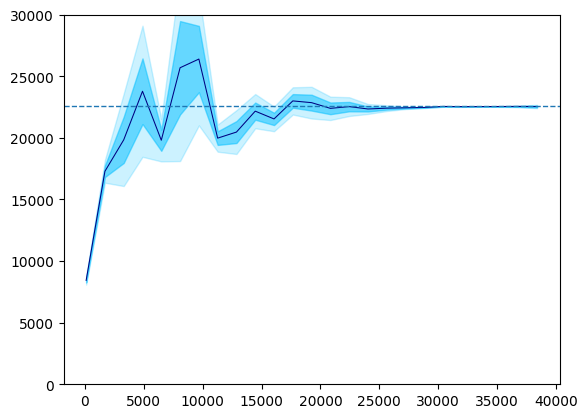

In [13]:
plt.plot(iterations, logXfs[0] * (-500), color='navy', lw=.75)
plt.fill_between(iterations, (logXfs[0] - logXfs[1]) * -500, (logXfs[0] + logXfs[1]) * -500, color='deepskyblue', alpha=0.5)
plt.fill_between(iterations, (logXfs[0] - 2*logXfs[1]) * -500, (logXfs[0] + 2*logXfs[1]) * -500, color='deepskyblue', alpha=0.2)
plt.axhline(logXf_true * (-500), lw=1, ls='--')
plt.ylim(0, 30000)

#### Wedding cake

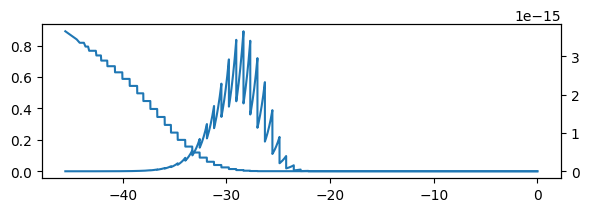

In [14]:
from aeons.toy_samples import wedding_cake_samples
nlive = 500
d, sigma = 10, 0.01
samples_w = wedding_cake_samples(nlive, d, sigma)
wedding = EndModel(samples_w)
wedding.plot_lx()

In [16]:
logXf_true = wedding.logXf_true(N=100, start=0.5)
logXf_true

-38.2524437311867

In [23]:
N = 50
iterations = np.linspace(100, 14000, N, endpoint=False).astype(int)
logXfs = wedding.logXfs(iterations, Nset=25)

(0.0, 20000.0)

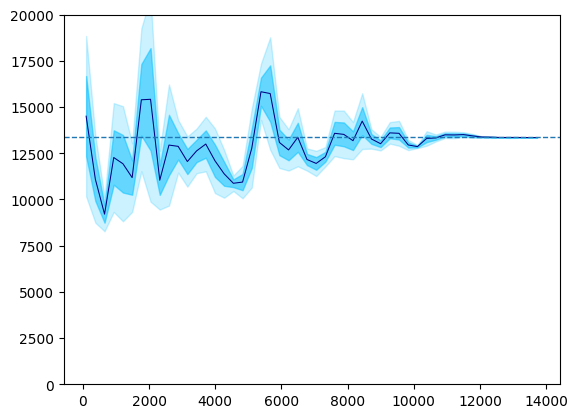

In [24]:
plt.plot(iterations, logXfs[0] * (-350), color='navy', lw=.75)
plt.fill_between(iterations, (logXfs[0] - logXfs[1]) * -350, (logXfs[0] + logXfs[1]) * -350, color='deepskyblue', alpha=0.5)
plt.fill_between(iterations, (logXfs[0] - 2*logXfs[1]) * -350, (logXfs[0] + 2*logXfs[1]) * -350, color='deepskyblue', alpha=0.2)
plt.axhline(logXf_true * (-350), lw=1, ls='--')
plt.ylim(0, 20000)

In [18]:
ndead = 1768
points = points_at_iteration(samples_w, ndead)
logL = np.array(points.logL)
nk = np.array(points.nlive)
logXf = []
for _ in range(25):
    X = generate_Xs(nk)
    theta = analytic_lm_params(logL[ndead:], X[ndead:], 1)
    logZdead = logsumexp(points.logw()[:ndead])
    logXf.append(logXf_formula(theta, logZdead, X[ndead]))